# YOLO

In [2]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
print(len(classes))
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


In [10]:


# Get the names of the output layers

import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.figure(figsize=(12,12))
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]  #3개의 yolo layer

# Draw the predicted bounding box
def drawPred(i, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%d  %s:%s' % (i, classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
#     cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
#     cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:           # 모든 출력층에 대해서 계산
        for detection in out:
            scores = detection[5:]      
            classId = np.argmax(scores)      # 최대 확률값 가져온다.
            confidence = scores[classId]
            if confidence >  0.0:   # 객체확률
                center_x = int(detection[0] * frameWidth) 
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    # nms가 너무 낮으면  겹치는 객체를 감지하지 못함
    # nms가 너무 크면 같은 객체에 대해서 box 많이 사용, 합칠지 말지 결정
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(i, classIds[i], confidences[i], left, top, left + width, top + height)

In [30]:
cap = cv2.VideoCapture('cars3.jpg')

hasFrame, frame = cap.read()
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], True, crop=False)

net.setInput(blob)

In [38]:
print(getOutputsNames(net))

['yolo_82', 'yolo_94', 'yolo_106']


In [31]:
%%time
outs = net.forward(getOutputsNames(net))
print(len(outs))# 출력물이 세개다
print(outs[0].shape) # 507 = 13 * 13 * 3, 85 -> 4(오브젝트 좌표) + 1(객체일 확률) + 80(클래스일 확률)
print(outs[1].shape) # 2028 = 26 * 26 * 3 
print(outs[2].shape) # 8112 = 52 * 52 * 3
print(outs[0][0]) # 객체 좌표는 0~1값으로 정규화 되어있다. 객체일 확률이 0에 가까우면 클래스일 확률도 0

3
(507, 85)
(2028, 85)
(8112, 85)
[4.6652056e-02 5.9343114e-02 4.0227854e-01 1.3376191e-01 3.8681057e-07
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 

In [35]:
frameHeight = frame.shape[0]
frameWidth = frame.shape[1]

# Scan through all the bounding boxes output from the network and keep only the
# ones with high confidence scores. Assign the box's class label as the class with the highest score.
classIds = []
confidences = []
boxes = []

out = outs[1]

# for out in outs:           # 모든 출력층에 대해서 계산
for detection in out:
    scores = detection[5:]      
    classId = np.argmax(scores)      # 최대 확률값 가져온다.
    confidence = scores[classId]
    if confidence >  0.0:   # 객체확률
        center_x = int(detection[0] * frameWidth) 
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])
        print(center_x,center_y,width,height,classId, confidence)

352 302 79 122 5 0.9234842
737 308 60 81 7 0.9210711
187 327 78 88 5 0.5885871
114 384 77 71 2 0.5930967
346 428 138 87 2 0.516284
495 494 82 71 2 0.54869854
655 506 72 67 2 0.83266896
970 516 90 81 7 0.3152271
541 542 116 82 2 0.7852924
697 534 86 76 2 0.88050604
765 570 104 88 2 0.76030135
766 568 111 85 7 0.20014168
573 587 127 94 2 0.8882573
856 590 148 142 2 0.79524213
639 626 189 126 2 0.5977327
937 615 170 139 2 0.98294973


In [37]:
# indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
for i in range(len(boxes)):
    i = i[0]
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    drawPred(i, classIds[i], confidences[i], left, top, left + width, top + height)
    

TypeError: 'int' object is not subscriptable

In [33]:
postprocess(frame, outs)

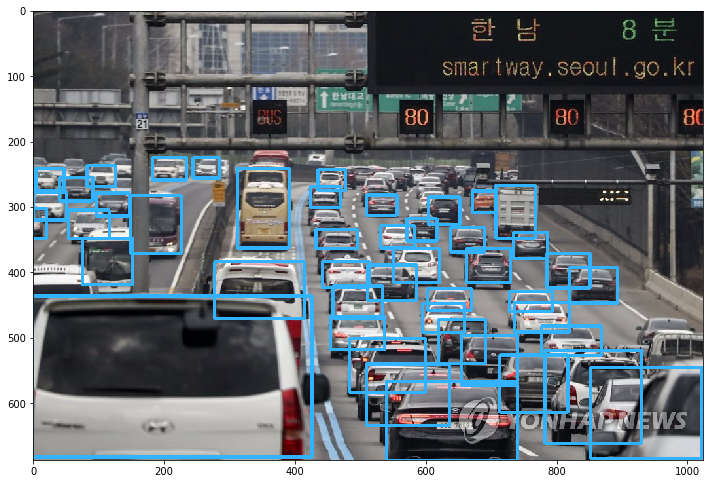

In [34]:
imshow("", frame)